# Thermal Model for CubeSat

The aim of this tutorial is to set up a satellite thermal nodal model in order to assess the power requirements of the thermal control system.

## Two nodes thermal model

The paper [[Rossi, 2013](#References)] outlines the creation of a Thermal Model Analysis for a CubeSat as based on the SwissCube's flight data from 2009 to 2012. The external faces and internal components of the CubeSat were simplified into two nodes of the aforementioned respective general locations, with the external node pertaining to a spherical surface representative of the six-phases of a CubeSat 1U at mean temperature, and the internal node being based on the thermally controlled battery pack. 

*SwissCube thermal model:* 
![SwissCubeThermalModel](./figures/SwissCubeThermalModel.PNG)

The above illustrated figures show the simplified two node model defined to eventually simulate heat transfers between and within the internal and external references of a cube satellite (left), and the comparison or validation of the created thermal model by [[Rossi, 2013](#References)] as compared to the actual experimental data from the SwissCube satellite (right).

The heat transfer in terms of conduction and radiation were analyzed with each node's interactions with the environment and with each other were taken into account with respect to the Fourier and Stefan-Boltzmann Equations, as well as Lambert's law, to ultimately arrive to the following equations:<br><br>
[1] Solar Radiation: $$q_s=A_s\alpha_sJ_s$$
[2] Infrared from Earth: $$q_p=A_pF_{s-p}\varepsilon\sigma_nT_p^4$$
[3] Albedo: $$q_a=A_pF_a\alpha_sJ_sa$$
[4] Radiation to Deep Space: $$q_r=A_r\varepsilon\sigma_nT^4$$<br>
Among which the first three equations refer to heat input, and the last to heat output. Where $A$ generally refers to the area, $\alpha$ the absorptivity, $J_s$ the Solar Constant mean value, $F$ the geometric view factor, $\varepsilon$ the emmisivity, $\sigma$ the Stefan-Boltzmann constant, and $T$ the absolute temperature. 



In a more general context, the following equation was used, and the coefficients K and R were derived from the assumption of two concentric nodal spheres with specified radii.<br><br>
$$C_i\frac{dT_i}{dt}=\sum_{i\not=j}K_{ij}(T_j-T_i)+\sum_{i\not=j}R_{ij}(T_j^4-T_i^4)+q_i$$
$$i,j=1,...,n$$<br>
$$K=\frac{4\pi\lambda r_{int}r_{ext}}{r_{ext}-r_{int}}$$<br>
$$R=\frac{4\pi r_{int}^2}{\frac{1}{\varepsilon_{int}}+\frac{1-\varepsilon_{ext}}{\varepsilon_{ext}}(\frac{r_{int}}{r_{ext}})^2}$$<br>

$R_{int}$ and $\lambda$ parameters was tuned given the flight data and theoretical values. The above figure shows the differential equation with respect to the evolution of time in the system. Overall, the simplified model was proven to be close and consistent in terms of slopes with regards to the actual flight data. To be able to use this lumped parameters model, it is necessary to adapt the value of the parameters to the configurations of interest.

*Tuned SwissCube parameters:*
<img src="./figures/SwissCubeParameters.png" width="300">


In [25]:
import math  
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

S = 0.06 # [m²] Cubesat surface
A = 0.06462 # [m²] Total area for heat transfers
A_s = 0.03231 # [m²] Area facing the sun
A_p = 0.03231 # [m²] Area facing the planet
A_r = 0.06462 # [m²] Radiating area
F_sp = 0.5 # [-] view factor between CubeSat and the planet
F_a = 0.5 # [-] view factor for the Albedo
J_s = 1366 # [W/m²] Mean of the Sun Power
E_ext = 0.9 # [-] Emissivity surface
E_int = 0.8 # [-] Emissivity internal part
SB_const = 5.67e-8 # [-] Stefan Boltzman constant
a = 0.34 # [-] Mean albedo value
T_p = 288 # [-] Planet temperature
ABS_const = 0.65 # [K] Absorbance coefficient
C_int = 80 # [J/K] Internal node capacity
C_ext = 570  # [J/K] External node capacity
HC = 0.25 # [W/mK] Heat conductivity



K: 0.0026376
R: 4.0824e-10


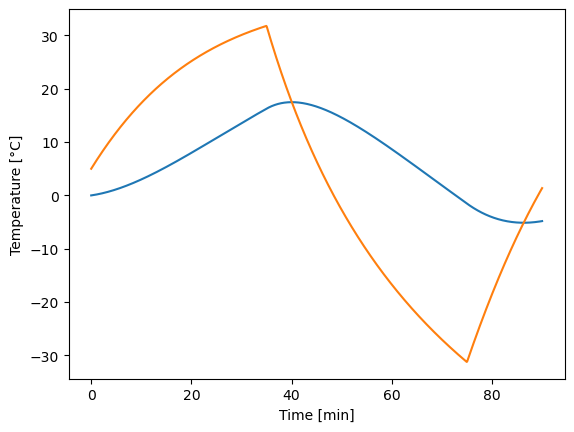

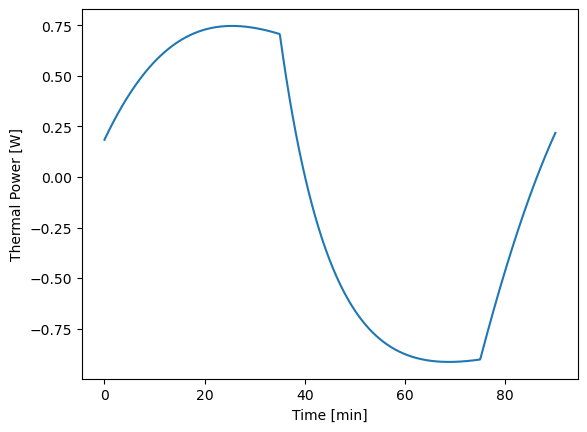

In [26]:
# The value below is supposed to be the temperature for deep space
# Not sure about this, as it doesn't make much sense for q_r to just be zero
T = 0

r_ext = math.sqrt(S/(4*math.pi))
r_int = 0.01

# Conduction
# K = -(4*math.pi*HC*r_ext*r_int)/(r_ext-r_int)*0+1


# calculate this coefficient  assuming that the corresponding thermal resistance is due to spacers
# Rth = L / kS
Dspacer = 6e-3 # [m] spacer diameter
Lspacer = 15e-3 # [m] length of a spacer
Sspacer = 3.14*(Dspacer/2)**2 # [m²] area with diameter
kspacer = 0.35 # [W/m/K] thermal conductivity

nspacer = 4 # [-] spacers number

Rth = Lspacer/kspacer/Sspacer
K = nspacer/Rth

# Radiation
# R = (4*math.pi*(r_int**2)*SB_const)/((1/E_int)+(((1-E_ext)/E_ext)*((r_int/r_ext)**2)))

R = 2*(70e-3*70e-3)*SB_const/(1/E_int+1/E_ext-1)

q_p = A_p*F_sp*E_ext*SB_const*(T_p**4) # Planet radiation
q_r = A_r*E_ext*SB_const*(T**4)

def model(y,t):
    global power
    T1 = y[0] # Internal temperature
    T2 = y[1] # External temperature

    if t<35*60:
      q_int = 0
      q_s = A_s*ABS_const*J_s # Sun power
      q_a = A_p*F_a*ABS_const*J_s*a # Albedo power
    elif t<75*60:
      q_int = 0
      q_s = 0
      q_a = 0
    else:
      q_int = 0
      q_s = A_s*ABS_const*J_s
      q_a = A_p*F_a*ABS_const*J_s*a

    q_sp = A_p*F_sp*E_ext*SB_const*((T2+273.15)**4) # Satellite -> Planet radiation
    q_sr = A_r*E_ext*SB_const*((T2+273.15)**4) # Satellite -> Space radiation 

    # Power exchange between external and internal node
    Pint=(K*(T2-T1))+(R*((T2+273.15)**4-(T1+273.15)**4)) + q_int
        #utilized q_int to keep heat target
        #find a peak value for Power so it doesn't get too cold; hysterisis control
    
    # Internal temperature variation
    dT1dt = Pint/C_int

    # External temperature variation
    dT2dt = ((K*((T1-T2)))+(R*((T1+273.15)**4-(T2+273.15)**4)) + q_s + q_p + q_a + q_r - q_sp - q_sr)/C_ext
    
    dydt = [dT1dt,dT2dt]

    return dydt

y0 = [0,5]
t = np.linspace(0,90*60,1000)
y = odeint(model,y0,t)

print('K: ' + str(K))
print('R: ' + str(R))

plt.plot(t/60,y)
plt.xlabel('Time [min]')
plt.ylabel('Temperature [°C]')
plt.show()

T1=y[:,0]
T2=y[:,1]
Pint=K*(T2-T1)+R*((T2+273.15)**4-(T1+273.15)**4)

plt.plot(t/60,Pint)
plt.xlabel('Time [min]')
plt.ylabel('Thermal Power [W]')
plt.show()

## Thermal conductance

The conductive heat transfer term depends on the nature and shape of the fasteners linking the cards to the satelitte structure. 
Nylon, invar or permaglass can be used to make cylinder-like spacers. 

| Material | Thermal conductivity |
| --- | --- |
| Nylon | 0.25 W/mK  |
| Invar | 5.8 W/mK  |
| Stainless steel | 14 W/mK | 
| Permaglass | 0.35 W/mK   |

Note: Nylon has less mechanical strength at high temperatures. 

> **Question:** Suggest the expression for a conduction term $K$ corresponding to 4 spacers of diameter $D_{spacer}$ and length $L_{spacer}$.

## Thermal radiation

Le terme de transfert thermique en radiation Thermal radiation 


En rayonnement:
- coefficient d'emissivité de surfaces typiques (fonction de la peinture par exemple) a priori plutot partir sur des plans


## Thermal Capacitance

# Specification and Simulation
*Defining the Needs for a CubeSat Battery Pack Heating Solution*

####**INFORMATION ON CUBESAT BATTERIES** 🔋
---

*   The **OPTIMUS Battery** from [AAC Clyde Space](https://www.aac-clyde.space/what-we-do/space-products-components/cubesat-batteries) has strings of cells connected in parallel with cell protection electronics and autonomous integrated heater systems for thermal control. It's available in varrying battery range capacities [*30, 40, and 80 Wh*].
*   The [SwissCube Satellite](https://https://pw-sat.pl/wp-content/uploads/2014/07/PW-Sat2-A-03.00-EPS-PRR-EN-v1.1.pdf) utilized two (2) **Varta PoLiFlex LiPo [*Lithium Polymer*]** PLF503759 batteries with a maximum voltage of 4.2 V and a capacity of 1210 mAh
*   The Varta PoLiFlex LiPo [PLF503759](https://docs.rs-online.com/a8d7/0900766b80b23eef.pdf) has a typical capacity of 1300 mAh, nominal voltage of 3.7 V, nominal capacity of 1250 mAh, mass of 22.5 g, and dimensions of **58.7 x 5.2 x 37.0 mm (L-H-W)**


####**EVALUATION OF THERMAL CAPACITANCE** 💡
---
Try to evaluate the thermal capacitance of a battery pack composed of :
- 2 Varta cells
- One aluminum box (thickness 1mm)
- 1 mm thick epoxy resin

The inner dimensions of the box are 11.7 mm x 39 mm x 66 mm, which gives enough space for two batteries.

$C_{th,total}=c_{alu}.M_{alu}+c_{lipo}.M_{lipo}+c_{epoxy}.M_{epoxy}$<br><br>
with the assumptions:<br>
$c_{lipo}=1000 J/(kg.K)$ and $m=22.5g$<br>
[$c_{alu}=896 J/(kg.K)$ and $\rho_{alu}=2.7 g/cc	$](https://asm.matweb.com/search/SpecificMaterial.asp?bassnum=ma6061t6)<br>
[$c_{epoxy}=300 J/(kg.K)$ and $\rho_{epoxy}=1.44 g/cc$](https://www.matweb.com/search/datasheet_print.aspx?matguid=c1ec1ad603c74f628578663aaf44f261)

In [ ]:
c_lipo = 1000
c_alu = 896
c_epoxy = 300

p_alu = 2.7
p_epoxy = 1.44

l = 1.17
w = 3.9
h = 6.6

SA = (2*l*w) + (2*l*h) + (2*w*h)

m_lipo = 22.5/1000
m_alu = (2.7*0.1*SA)/1000
m_epoxy = (1.44*0.1*SA)/1000

C_th_tot = (2*c_lipo*m_lipo) + c_alu*m_alu + c_epoxy*m_epoxy
print("C_th_total: " + str(C_th_tot) +" J/K")

print("C_th_alu = %.2f"%(c_alu*p_alu*(l+0.1)*(w+0.1)*(h+0.1)/1000))

C_th_total: 66.683376 J/K
C_th_alu = 82.34


####**DEFINITION OF EQUIVALENT ALUMINUM BOX** ⏹
---
*   The dimensions will be scaled to that of the SwissCube Satellite's Varta PoLiFlex LiPo PLF503759, with **58.7 mm length**, **37.0 mm width**, and **5.2 mm height or thickness**
*   **6061-T6 Aluminum** with a thermal capacitance of 237 J/kg-K and density of 2.7 g/cm^3 is commonly used in satellite applications
* Basing off the Research Paper's reference to internal node capacity being 80 J/K, the dimensions of the equivalent aluminum box was previously computed as 13.08 cm length, 8.25 cm width, and 1.16 cm height/thickness

In [15]:
import sympy as sym
import numpy as np
from sympy import solve, Eq
from sympy.abc import x, y, z, a, b

volume = 66.683376/(896*(2.7/1000))
sol = sym.solve(Eq((5.87*x)*(3.7*x)*(0.52*x), volume), x)
x = sol[0]
l = 5.87*x
w = 3.7*x
h = 0.52*x

print('Volume: ' + str(volume))
print('Scaling Factor: ' + str(x))
print('Length: ' + str(l))
print('Width: ' + str(w))
print('Height/Thickness: ' + str(h))


Volume: 27.564226190476187
Scaling Factor: 1.34637967027869
Length: 7.90324866453589
Width: 4.98160478003114
Height/Thickness: 0.700117428544917


With this, all dimensions of the Varta PoLiFlex LiPo PLF503759 shall be multiplied by **2.23** to stay on a scaled factor and obtain a total Thermal Capacitance of **80 J/K**, obtaining the following final equivalent dimensions: **7.90 cm length**, **4.98 cm width**, and **0.700 cm height/thickness**

####**2-NODE THERMAL MODEL OF SWISSCUBE** 🌡
---
Note that the model is not to scale but follows the same trend as that of the study by Rossi and Ivanov.

K: 0.10048
R: 1.381475138121547e-11


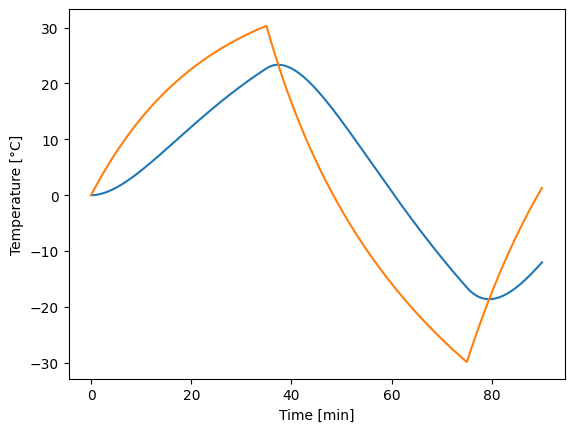

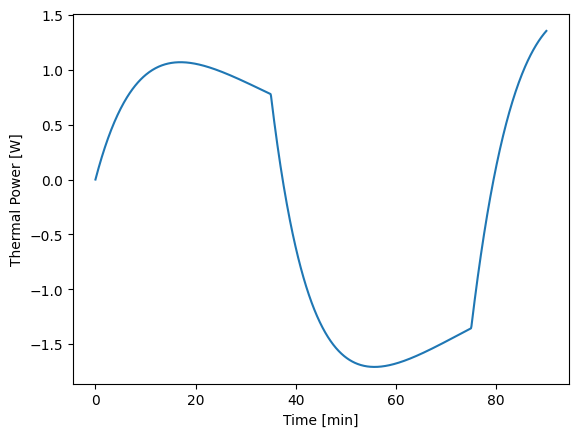

In [31]:

r_int = 0.01

# Conduction
# K = -(4*math.pi*HC*r_ext*r_int)/(r_ext-r_int)*0+1

# calculate this coefficient  assuming that the corresponding thermal resistance is due to spacers
# Rth = L / kS
Lspacer = 10e-3 # [m] length of a spacer
Sspacer = 3.14*(8e-3/2)**2/2 # [m²] area with diameter 8mm
kspacer = 0.25*0+10 # [W/m/K] thermal conductivity

nspacer = 4 # [-] spacers number

Rth = Lspacer/kspacer/Sspacer
K = nspacer/Rth

# Radiation
# R = (4*math.pi*(r_int**2)*SB_const)/((1/E_int)+(((1-E_ext)/E_ext)*((r_int/r_ext)**2)))

R = (70e-3*70e-3)*SB_const/(1/E_int+1/E_ext-1)

q_p = A_p*F_sp*E_ext*SB_const*(T_p**4)
q_r = A_r*E_ext*SB_const*(T**4)

def model(y,t):
    global power
    T1 = y[0]
    T2 = y[1]

    if t<35*60:
      q_int = 0
      q_s = A_s*ABS_const*J_s
      q_a = A_p*F_a*ABS_const*J_s*a
    elif t<75*60:
      q_int = 0
      q_s = 0
      q_a = 0
    else:
      q_int = 0
      q_s = A_s*ABS_const*J_s
      q_a = A_p*F_a*ABS_const*J_s*a

    q_sp = A_p*F_sp*E_ext*SB_const*((T2+273.15)**4)
    q_sr = A_r*E_ext*SB_const*((T2+273.15)**4)

    Pint=(K*(T2-T1))+(R*((T2+273.15)**4-(T1+273.15)**4)) + q_int
        #utilized q_int to keep heat target
        #find a peak value for Power so it doesn't get too cold; hysterisis control
    dT1dt = Pint/C_int

    dT2dt = ((K*((T1-T2)))+(R*((T1+273.15)**4-(T2+273.15)**4)) + q_s + q_p + q_a + q_r - q_sp - q_sr)/C_ext
    # print(((K*(T2-T1))+(R*((T2+273.15)**4-(T1+273.15)**4)) + q_int)/C_int)
    dydt = [dT1dt,dT2dt]

    return dydt

y0 = [0,0]
t = np.linspace(0,90*60,1000)
y = odeint(model,y0,t)

print('K: ' + str(K))
print('R: ' + str(R))

plt.plot(t/60,y)
plt.xlabel('Time [min]')
plt.ylabel('Temperature [°C]')
plt.show()

T1=y[:,0]
T2=y[:,1]
Pint=K*(T2-T1)+R*((T2+273.15)**4-(T1+273.15)**4)

plt.plot(t/60,Pint)
plt.xlabel('Time [min]')
plt.ylabel('Thermal Power [W]')
plt.show()

####**POWER NECESSARY FOR A CONSISTENT 15°C** ⚡️
---

**NOTE**: Use the following equation: *Power = Heat Load for Desired Temperature / (Thermal Capacitance * Efficiency)*

>   "In this way the heat produced by the resistance inside the battery-box has been setup to turn off once the temperature is over 5ºC and turn on when below the -5ºC. While turned on, in SwissCube, it produces between 100 mW and 150 mW: **in the model it has been used 100 mW**"

SwissCube's batteries only performed at [maximum 25% efficiency](https://www.eoportal.org/satellite-missions/swisscube#rf-communications). The heat load to 5ºC is 100 mW, therefore that until 15ºC is computed below along with the equivalent necessary power.

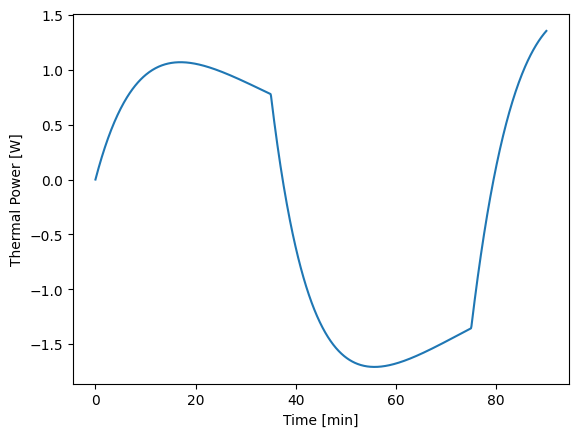

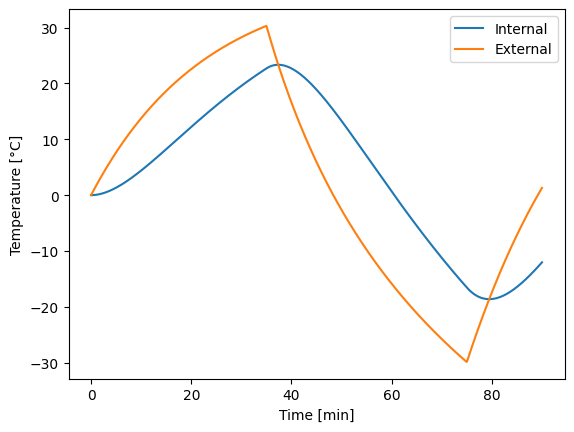

Maximum Temperature of Internal Node (T1): 23.343665483525747 °C
Minimum Temperature of Internal Node (T1): -18.620854817968667 °C


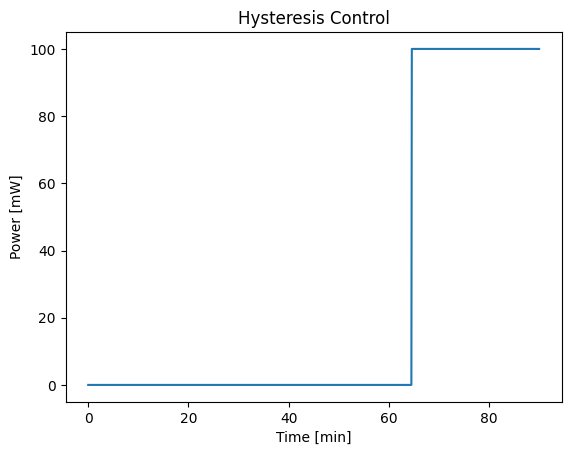

Peak Power: 1.353387383482923 W
Mean Power: -0.17737055770976012 W


In [59]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

S = 0.06
A = 0.06462
A_s = 0.03231
A_p = 0.03231
A_r = 0.06462
F_sp = 0.5
F_a = 0.5
J_s = 1366
E_ext = 0.9
E_int = 0.05*1+0.5*0
SB_const = 5.67e-8
a = 0.34
T_p = 288
ABS_const = 0.65
C_int = 80
C_ext = 570
HC = 0.25

# As derived from the literature
T_lower = -5  # Lower temperature threshold (in °C)
T_upper = 5  # Upper temperature threshold (in °C)

T = 0
r_ext = math.sqrt(S / (4 * math.pi))
r_int = 0.01

# Calculate this coefficient  assuming that the corresponding thermal resistance is due to spacers
# Rth = L / kS
Lspacer = 10e-3  # [m] length of a spacer
Sspacer = 3.14 * (8e-3 / 2) ** 2 / 2  # [m²] area with diameter 8mm
kspacer = 0.25 * 0 + 10  # [W/m/K] thermal conductivity
nspacer = 4  # [-] spacers number

Rth = Lspacer / kspacer / Sspacer
K = nspacer / Rth

R = (70e-3 * 70e-3) * SB_const / (1 / E_int + 1 / E_ext - 1)

def model(y,t):
    global power
    T1 = y[0]
    T2 = y[1]

    if t<35*60:
      q_int = 0
      q_s = A_s*ABS_const*J_s
      q_a = A_p*F_a*ABS_const*J_s*a
    elif t<75*60:
      q_int = 0
      q_s = 0
      q_a = 0
    else:
      q_int = 0
      q_s = A_s*ABS_const*J_s
      q_a = A_p*F_a*ABS_const*J_s*a

    q_sp = A_p*F_sp*E_ext*SB_const*((T2+273.15)**4)
    q_sr = A_r*E_ext*SB_const*((T2+273.15)**4)

    Pint=(K*(T2-T1))+(R*((T2+273.15)**4-(T1+273.15)**4)) + q_int
    dT1dt = Pint/C_int

    dT2dt = ((K*((T1-T2)))+(R*((T1+273.15)**4-(T2+273.15)**4)) + q_s + q_p + q_a + q_r - q_sp - q_sr)/C_ext
    # print(((K*(T2-T1))+(R*((T2+273.15)**4-(T1+273.15)**4)) + q_int)/C_int)
    dydt = [dT1dt,dT2dt]

    return dydt

y0 = [0, 0]
t = np.linspace(0, 90 * 60, 1000)

y = odeint(model, y0, t)

T1 = y[:, 0]
T2 = y[:, 1]
Pint = K * (T2 - T1) + R * ((T2 + 273.15) ** 4 - (T1 + 273.15) ** 4)

def power_control(temperature):
    if temperature <= T_lower:
        return 100
    elif temperature > T_upper:
        return 0
    else:
        return 0

T1=y[:,0]
T2=y[:,1]
Pint=K*(T2-T1)+R*((T2+273.15)**4-(T1+273.15)**4)

plt.plot(t/60,Pint)
plt.xlabel('Time [min]')
plt.ylabel('Thermal Power [W]')
plt.show()

plt.plot(t/60,y)
plt.xlabel('Time [min]')
plt.ylabel('Temperature [°C]')
plt.legend(['Internal', 'External'])
plt.show()

max_temperature = np.max(T1)
min_temperature = np.min(T1)

print("Maximum Temperature of Internal Node (T1):", max_temperature, "°C")
print("Minimum Temperature of Internal Node (T1):", min_temperature, "°C")

power_values = [power_control(temp) for temp in T1]

plt.plot(t / 60, power_values)
plt.xlabel('Time [min]')
plt.ylabel('Power [mW]')
plt.title('Hysteresis Control')
plt.show()

# With the literature, it was said that the active control of 100mW was only activated
# once the temperature reached -5 degrees Celcius, and stopped once it reached 5 degrees Celsius

peak_power = np.max(Pint)
mean_power = np.mean(Pint)

print("Peak Power:", peak_power, "W")
print("Mean Power:", mean_power, "W")

In [55]:
# Computing for necessary resistance

power_mW = 100  # Power in milliwatts
voltage = 12  # Voltage of ideal batteries in volts

# P = IV therefore I = P / V
current = (power_mW / 1000) / voltage
resistance = voltage / current

print("Resistance (R):", resistance, "Ohms")

Resistance (R): 1440.0 Ohms


## References 

[Rossi, 2013] Rossi, S., & Ivanov, A. (2013). Thermal model for cubesat: A simple and easy model from the Swisscube’s thermal flight data. In *Proceedings of the International Astronautical Congress* (Vol. 13, pp. 9919-9928). [Link](https://www.researchgate.net/publication/299535685_THERMAL_MODEL_FOR_CUBESAT_A_SIMPLE_AND_EASY_MODEL_FROM_THE_SWISSCUBE%27S_THERMAL_FLIGHT_DATA)